In [17]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
connection = pymysql.connect(host = '35.192.176.126', user = 'root', password = 'pass123', 
      db = 'titanic', charset = 'utf8mb4', cursorclass = pymysql.cursors.DictCursor)

In [3]:
cursor = connection.cursor()

In [4]:
statement = "Select elapsed_time, age, evaluation_year, tree, `FullDataSet False Positives`, `FullDataSet False Negatives`, `FullDataSet Num Elements`, id, optimization, generation from individuals join paretofront on individuals.hash=paretofront.hash where paretofront.generation=(select max(paretofront.generation));"
cursor.execute(statement)

526

In [5]:
df = pd.read_sql(statement, connection)

In [6]:
df.head()

,elapsed_time,age,evaluation_year,tree,FullDataSet False Positives,FullDataSet False Negatives,FullDataSet Num Elements,id,optimization,generation
0,5.60359,1.0,0,"myPlanckTaper(AdaBoostLearner(myGaussian(ARG0,...",18.8,19.0,35.0,1,0,0
1,115.82500,1.0,0,"BaggedLearner(ARG0, learnerType('Blup', None))",16.0,36.4,27.0,2,0,0
2,5.53096,1.0,0,"AdaBoostLearner(ARG0, learnerType('ExtraTrees'...",16.2,21.8,44.0,3,0,0
3,5.60359,1.0,0,"myPlanckTaper(AdaBoostLearner(myGaussian(ARG0,...",18.8,19.0,35.0,4,0,1
4,5.48483,1.0,0,"AdaBoostLearner(myProd(ARG0, 0), ModifyLearner...",0.0,68.4,29.0,5,0,1


In [7]:
df.max()

elapsed_time                                                             211.687
age                                                                            1
evaluation_year                                                               17
tree                           myPlanckTaper(AdaBoostLearner(myGaussian(myBar...
FullDataSet False Positives                                                109.8
FullDataSet False Negatives                                                 68.4
FullDataSet Num Elements                                                      82
id                                                                           526
optimization                                                                   2
generation                                                                    16
dtype: object

In [8]:
mogp_df = df[["FullDataSet False Positives", "FullDataSet False Negatives"]]
mogp_df = mogp_df.apply(pd.to_numeric)

In [9]:
mogp_df["FullDataSet False Positives"] = (mogp_df["FullDataSet False Positives"]/109.8)
mogp_df["FullDataSet False Negatives"] = (mogp_df["FullDataSet False Negatives"]/68.4)

In [10]:
input_data = mogp_df.to_numpy()

In [11]:
input_data

array([[0.1712204 , 0.27777778],
       [0.14571949, 0.53216374],
       [0.14754098, 0.31871345],
       ...,
       [0.10200364, 0.69590643],
       [0.07468124, 0.43859649],
       [0.10564663, 0.29824561]])

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#  Fairly fast for many datapoints, less fast for many dimensions
def find_pareto(data):
    is_Pareto = np.ones(data.shape[0], dtype = bool)
    for i, c in enumerate(data):
        # Keep any point with a lower cost
        if is_Pareto[i]:
            # This is where you would change for miniminzation versus maximization 

            # Minimization
            is_Pareto[is_Pareto] = np.any(data[is_Pareto]<c, axis=1)   

            # And keep self
            is_Pareto[i] = True  

    # Downsample from boolean array
    Pareto_data = data[is_Pareto, :]

    # Sort data
    Pareto_out =  Pareto_data[np.argsort(Pareto_data[:,0])]

    #return is_Pareto
    return Pareto_out


myData = mogp_df

# Include the trival Pareto points, i.e. always on or off
myData = np.vstack(([[0,1],[1,0]], myData))

# Use above routine to find pareto points
myPareto=find_pareto(myData)

# Calculate the Area under the Curve as a Riemann sum
auc = np.sum(np.diff(myPareto[:,0])*myPareto[0:-1,1])

# Create figure
plt.figure()

# Make sure font sizes are large enough to read in the presentation
plt.rcParams.update({'font.size': 14})

# Plot all points
plt.scatter(myData[:,0],myData[:,1],)

# Plot Pareto steps. note 'post' for minimization 'pre' for maximization
plt.step(myPareto[:,0], myPareto[:,1], where='post')
#plt.step(myPareto[:,0], myPareto[:,1], where='pre')

# Make sure you include labels
# Minimization
plt.title('Minimization Result\n with AUC = ' + str(auc))
plt.xlabel('False Negative')
plt.ylabel('False Positive')

plt.show()
plt.savefig("emade-pareto.png")

/Users/krithikacharya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


<Figure size 640x480 with 1 Axes>

In [13]:
statement = "select sum(elapsed_time)/1048 from individuals where `FullDataSet False Negatives` is not null;"
cursor.execute(statement)

1

In [14]:
cursor.fetchall()

[{'sum(elapsed_time)/1048': 64.33731482001662}]

In [ ]:
###TODO: compare elapsed time beween notnull vs null, make pretty charts!

In [22]:
statement = "select sum(elapsed_time)/4773 from individuals where `FullDataSet False Negatives` is null;"
cursor.execute(statement)

1

In [23]:
cursor.fetchall()

[{'sum(elapsed_time)/4773': 12.072379009942951}]

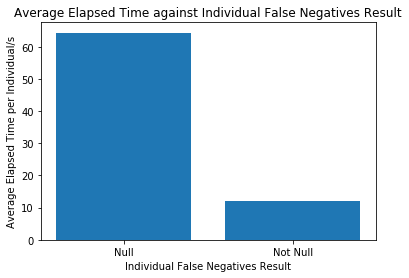

In [29]:
false_negatives = ['Null', 'Not Null']
elapsed_time = [64.33731482001662, 12.072379009942951]
plt.bar(false_negatives, elapsed_time)
plt.title('Average Elapsed Time against Individual False Negatives Result')
plt.ylabel('Average Elapsed Time per Individual/s')
plt.xlabel('Individual False Negatives Result')
plt.show()

In [26]:
# statement = "select sum(elapsed_time)/1048 from individuals where `FullDataSet False Positives` is not null;"
# cursor.execute(statement)

1

In [27]:
# cursor.fetchall()

[{'sum(elapsed_time)/1048': 64.33731482001662}]

In [ ]:
# statement = "select sum(elapsed_time)/1048 from individuals where `FullDataSet False Positives` is not null;"
# cursor.execute(statement)